<a href="https://colab.research.google.com/github/gabrielcc2/atdbSS2019/blob/master/Range_search_with_learned_models_ATDBSS2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Range search with learned models**

---






# Introduction

Welcome everyone.

Today we're gonna have a look at how to support range queries with learned models. This notebook is an assignment from the course ["Advanced Topics in Databases"](http://www.dbse.ovgu.de/Lehre/ATDB.html), at the University of Magdeburg. Resolving the task should take between 2-3 hours, so plan accordingly.

Before jumping into action, some housekeeping notes:

1.  For submitting the task 5 items (identified in bold, as **submission items**) are required to be sent to campero@ovgu.de, by 30.06.19, 11:59 pm CET.  
2.   If there is any complication or there are questions with this assignment, feel free to reach out to campero@ovgu.de. To our knowledge one possible bug might happen when running the Keras training code boxes. The error is that the model starts training but does not seem to make any progress in the first set of epochs. It seems to be a silent error when connecting to the backend. Stopping and restarting the code box usually fixes this.
3.   To work with this notebook you will need to open it in Colab, and make a copy to your personal Google Drive. This is necessary to store some intermediate files. The Colaboratory site will guide you about what you need to do.
4.   Another pertinent tip, for using Colab: remember to pick a GPU runtime (Edit->Notebook settings), to train the neural network models faster. If you would like to know (optionally) how to train the models we have with the TPUs currently provided, there are some references available [here](https://medium.com/@jannik.zuern/using-a-tpu-in-google-colab-54257328d7da).
5.   If you need any help working with Colab, there are great resources [here](https://colab.research.google.com/notebooks/welcome.ipynb). It should not be specially challenging.

Traditionally range queries are supported with efficient index structures that allow you to determine the position of the item in the lower bound, the position of the item in the higher bound, and then the positions of items within.

An example of a range query could look like this: 
SELECT 
    * 
FROM
    lineitem
WHERE
    l_extendedprice >= 1000 AND l_extendedprice <= 10000;
    
These kind of queries are a basic building block in data exploration.

The idea of supporting this kind of queries with learned models comes from Kraska et al. (https://arxiv.org/abs/1712.01208). These authors had that insight that search can actually be replaced by inference, if there exists a model that maps between the search key and the target position where the item is to be found. This mapping can be ultimately powered by a regressor model.

Authors show that other tasks (such as existence queries, and point-lookups) can be supported with learned models too.

The use of these models, specially when they are compact, constitutes an elegant adaptation of a data structure to data characteristics. When these models are, in fact, sufficiently compact, the search over these models could be expected to be faster than search over the original data. Hence these are the cornerstone gains from the models: adaptation to the data, reduced storage, improved search. 

Today we're going to have a quick experiment on building such models, and in making them efficient at inference (i.e., the search task). 

Please note that the implementation offered for this task is purely illustrative. It is not intended to be representative of the actual state-of-the-art in building these structures.

Without further ado (and assuming that you've already opened the notebook in Colab), run the following block to install some dependencies, and let's get started.

In [0]:
!pip install matplotlib pandas seaborn sklearn keras 

print("Done installing dependencies.")

Done installing dependencies.


# First part: Data understanding

(Estimated time: 40 minutes)

First, you need to load our dataset. For this task we will be using the lineitem table from a TPC-H database of SF 0.01. From this dataset we will focus on learning a model for range queries on the extended price attribute.

Here is the overall schema for the TPC-H database:
![](https://docs.snowflake.net/manuals/_images/sample-data-tpch-schema.png)

Our data will be loaded from a Github repository. Run the code below to load it into a dataframe. 

In [0]:
import random
import pandas as pd

dataset_url = 'https://raw.githubusercontent.com/gabrielcc2/atdbSS2019/master/data/lineitem_SF0.01.tbl'
df = pd.read_csv(dataset_url, sep='|', header=0)

# Our dataset is now stored in a Pandas Dataframe

#Here we check the schema, and its length
print("Schema: "+str(df.columns))
print("Number of rows: "+str(len(df)))



Schema: Index(['L_ORDERKEY', 'L_PARTKEY', 'L_SUPPKEY', 'L_LINENUMBER', 'L_QUANTITY',
       'L_EXTENDEDPRICE', 'L_DISCOUNT', 'L_TAX', 'L_RETURNFLAG',
       'L_LINESTATUS', 'L_SHIPDATE', 'L_COMMITDATE', 'L_RECEIPTDATE',
       'L_SHIPINSTRUCT', 'L_SHIPMODE', 'L_COMMENT',
       'L_EXTENDEDPRICE_SORT_KEY'],
      dtype='object')
Number of rows: 60175


You will see that you have the same schema as defined in the TPC-H standard, but there is an addition of a column called  *L_EXTENDEDPRICE_SORT_KEY* .

This column will come in handy for our task.

Remember that our idea is to train a regressor model that maps from the *L_EXTENDEDPRICE*, to a location where items with that given price can be found. For simplicity, let's assume that this location can be the index of an array.

If this location were the actual index of the row, it would be very difficult to learn a precise model.

Run the code below to get a better sense of this difficulty. Here we plot how the prices (*L_EXTENDEDPRICE*) are distributed, and how they relate to the original index (*ORIGINAL_INDEX*). 


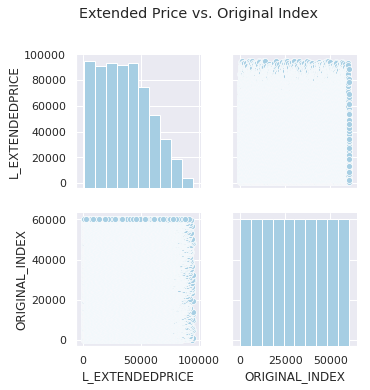

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
  

df['ORIGINAL_INDEX'] = df.index #For ease of use, we insert a new column with the original positions

df_for_plot= df[['L_EXTENDEDPRICE', 'ORIGINAL_INDEX']] #We only keep the columns that we'll use for the plot

"""
For zooming-in, feel free to consider only the first k indexes or prices in df2...

With the next 2 commands you sort on 'L_EXTENDEDPRICE' values, and retrieve only the first k rows

df_for_plot= df_for_plot.sort_values(['L_EXTENDEDPRICE']) #(or alternatively, df_for_plot.sort_values(['ORIGINAL_INDEX']))
df_for_plot=df_for_plot[:k]
"""
sns.set_palette("Paired")
g=sns.pairplot(df_for_plot)
g.fig.suptitle("Extended Price vs. Original Index", y=1.08)
plt.show()

You should see that the *L_EXTENDEDPRICE* goes up to 100k, with apparently few items being on the high end. You'll also see that the original index goes to 50k, with a fair distribution of items in each bin of the histogram.

You should also see that there is visible relation (as expected) between *L_EXTENDEDPRICE*  and the *ORIGINAL_INDEX*. This is even more evident in cases where there are duplicate prices (i.e., one price maps to several indexes).

Learning a model that maps between prices and these indexes would thus be very challenging. 

A workaround is to use a *Cummulative Density Function* (CDF) over the spread of the prices. This function gives us a nice 1:1 mapping between price and the CDF, while at the same time being monotonically increasing, and arguably easy to learn with a regressor.

In the next code snippet we construct the CDF for this attribute.

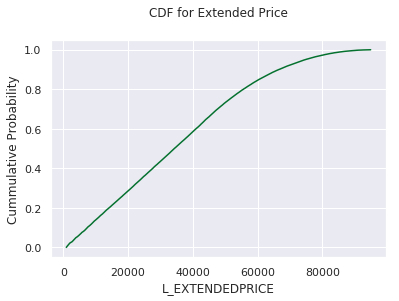

In [0]:
import numpy as np

#To calculate the actual CDF we need to define the unique values for the 'L_EXTENDEDPRICE'
unique_values= sorted(df['L_EXTENDEDPRICE'].unique())

#We create a histogram, counting the number of items per bin, and the boundaries of the bins
counts, bin_edges = np.histogram (df['L_EXTENDEDPRICE'], bins=unique_values)
prefix_sum = np.cumsum (counts) #This is a cummulative or prefix sum (https://en.wikipedia.org/wiki/Prefix_sum), tracking the sum of the number of items preceeding the list
cdf= prefix_sum/prefix_sum[-1]#Dividing by the last value in the list gives us the cdf


#Here we use as x the top boundaries of the bins, and as y the cdf 
df_for_plot = pd.DataFrame(np.array([bin_edges[1:], cdf]).T,
                    columns=["L_EXTENDEDPRICE", "Cummulative Probability"])
sns.set_palette("BuGn_r")
g= sns.lineplot(x="L_EXTENDEDPRICE", y="Cummulative Probability", data=df_for_plot)
g.set_title("CDF for Extended Price", y=1.08)
plt.show()



Using the CDF we added the *'L_EXTENDEDPRICE_SORT_KEY* attribute to our dataset. It simply represents the relative position of each value found.

To understand how this attribute lends itself to a mapping that is easier to learn, let's check how it relates to *L_EXTENDEDPRICE*.

Fill-in the following code block and run it, to check this relation. Once the plot is shown, zoom-in to the first 500 values (sorting on *L_EXTENDEDPRICE*) and save it (with any easy to understand filename) as **submission item # 1**. Optionally, you can compare too, in the same plot with the original indexes. 



In [0]:
df_for_plot= df[[]] #TODO: Fill-in the columns needed for the plot

#TODO: Add here the code to zoom-in to the first 500 values (sorting on 'L_EXTENDEDPRICE')
sns.set_palette("husl")
g= sns.pairplot(df_for_plot)
g.fig.suptitle("... vs. ...", y=1.08) #TODO: Fill-in
plt.show()

# Second part:  Model fitting

(Estimated time: 80 minutes)

*Regression* is the problem of predicting a target value (commonly a real-value), given an unlabled example. In order to solve this task a regression model is trained on a set of labeled data (e.g. to learn how to predict the weight of a person, based on features), such that the model can then be used to predict the target value of new unlabeled examples.

![An example of linear regression](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_predict_thumb.png)

For our case, however, we are not entirely concerned on learning for new data, instead the goal is to minimize the errors of the learned model on the training data itself. As a result, there is no test and train split.

In this section of the assignment we will create several models, and compare them. In specific, we will compare:

1. A simple linear regressor, against many others (only on the first 2k data points).
2. A SVM regressor of your choice, from the Scikit learn models (only on the first 2k data points).
3. A naive neural network.
4. A hierarhical neural network architecture.

In the following snippet we begin by defining in an easy manner our X and Y variables, and the subsets that we will use.



In [0]:
import copy
from sklearn import preprocessing

df=df.sort_values(['L_EXTENDEDPRICE'])
df['L_EXTENDEDPRICE_SCALED']=preprocessing.scale(df['L_EXTENDEDPRICE'])

X = np.array(df['L_EXTENDEDPRICE']).reshape(-1,1) #A necessary reshape
X_subset=X[:2000]#We will train first on a subset of 2k values. 

X_subset_scaled=np.array(df['L_EXTENDEDPRICE_SCALED']).reshape(-1,1) #A necessary reshape
X_subset_scaled=X_subset_scaled[:2000]

Y=df['L_EXTENDEDPRICE_SORT_KEY']
Y_subset=Y[:2000]#We will train first on a subset of 2k values

print("Done initializing subsets for training the scikit-learn regressors.")

Done initializing subsets for training the scikit-learn regressors.


Next we are going to train several models made available in scikit-learn. Please note that, since many of these models are more suitable for small to mid-sized data, we only evaluate them on a very limited subset of our dataset. Also note that we report the an evaluation on the original data (i.e., we make no train/test splits). Furthermore, we consider here mean absolute error, since it seems easier to understand (for this dataset) than the mean squared error.

This step could take some time.

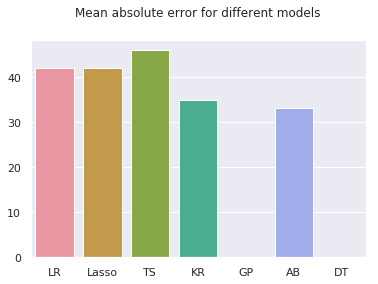

In [0]:
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

"""
For each regressor we have a similar workflow:
First, we define the regressor
Second, we fit the model
Third, we predict
Fourth, we evaluate the error
"""
def max_absolute_error(y, y_pred):
    return np.max(np.abs(y - y_pred))

max_ae=[]

#We begin with linear models, which have the nice feature of having a low number of
#coefficients, hence creating models that are compact (i.e., with a low memory footprint)
lr = linear_model.LinearRegression(n_jobs=5)#A linear regressor model. The simplest of the lot.
lr.fit(X_subset,Y_subset)
lr_predict= lr.predict(X_subset)
lr_mae=mean_absolute_error(Y_subset, lr_predict)
max_ae.append(max_absolute_error(Y_subset, lr_predict))

lasso = linear_model.Lasso(alpha=1.0) #A linear lasso model (least absolute shrinkage and selection operator)
#In addition to regression, Lasso models are also commonly employed for feature selection.
lasso.fit(X_subset, Y_subset)
lasso_predict=lasso.predict(X_subset)
lasso_mae=mean_absolute_error(Y_subset, lasso_predict)
max_ae.append(max_absolute_error(Y_subset, lasso_predict))

ts= linear_model.TheilSenRegressor(random_state=0) #A Theil-Sen model, a regressor based on an estimation of the
#geometrical median of the slopes of all possible lines connecting pairs of observations in the data
ts.fit(X_subset, Y_subset)
ts_predict=ts.predict(X_subset)
ts_mae=mean_absolute_error(Y_subset, ts_predict)
max_ae.append(max_absolute_error(Y_subset, ts_predict))


#We also consider a kernel ridge model. For this approach it is necessary to normalize the data on the X axis.
"""This, unfortunately does not learn a compact model, but stores a lot of data
which is also used to make the predictions."""
kr = KernelRidge(alpha=0.1, kernel='poly')#A kernel ridge model, with a linear kernel by default. We use a polynomial one.
kr.fit(X_subset_scaled, Y_subset) 
kr_predict=kr.predict(X_subset_scaled)
kr_mae=mean_absolute_error(Y_subset, kr_predict)
max_ae.append(max_absolute_error(Y_subset, kr_predict))

#We also consider a Gaussian process model
"""This, unfortunately has a large memory footprint."""
gpr = GaussianProcessRegressor(random_state=0)
gpr.fit(X_subset, Y_subset)
gpr_predict=gpr.predict(X_subset)
gpr_mae=mean_absolute_error(Y_subset, gpr_predict)
max_ae.append(max_absolute_error(Y_subset, gpr_predict))

#We also consider an AdaBoost model
ab= AdaBoostRegressor(random_state=0, n_estimators=100)
ab.fit(X_subset, Y_subset)  
ab_predict=ab.predict(X_subset)
ab_mae=mean_absolute_error(Y_subset, ab_predict)
max_ae.append(max_absolute_error(Y_subset, ab_predict))

#We also consider a Decision Tree model
dt = DecisionTreeRegressor(random_state=0)
dt.fit(X_subset, Y_subset)
dt_predict=dt.predict(X_subset)
dt_mae=mean_absolute_error(Y_subset, dt_predict)
max_ae.append(max_absolute_error(Y_subset, dt_predict))

#TODO: Add here an SVR model... don't forget to also add its max absolute error value to max_ae


mean_absolute_error_regressors=[lr_mae, lasso_mae, ts_mae, kr_mae, gpr_mae, ab_mae, dt_mae]
labels_regressors=["LR", "Lasso", "TS", "KR", "GP", "AB", "DT"]
summary = dict()
for i in range(0,len(labels_regressors)):
  summary[labels_regressors[i]]=dict()
  summary[labels_regressors[i]]["Mean Absolute Error"]=mean_absolute_error_regressors[i]
  summary[labels_regressors[i]]["Max Absolute Error"]=max_ae[i]
g = sns.barplot(x=labels_regressors, y=mean_absolute_error_regressors)
g.set_title("Mean absolute error for different models", y=1.08)
plt.show()


For your **submission item #2** extend the former code box with one Support Vector Regressor model. Here are examples: [SVR@sklearn](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html). Plot the results of this model  after the results of DT, in the former code box, and save the plot to a file, for your submission. Add to the filename, or in a note, the basic details about your configuration (e.g. SVR_deg3_gamma_auto.png). For this method, just like for Kernel Ridge regressor, it is good practice to use X_subset_scaled (otherwise it takes a lot of time to run, and the results are deteriorated).

Now let's take a look at how the predictions actually match for the models that you have.

First we do this on a subset of the first 10 values. For your **submission item #3**, produce and download the plot for the first 1000 values, and observe better how linear models give a reasonable approximation (though without visually seeming to improve over GP and DT). This might take some minutes to run.

If the SVR was not possible to implement, still submit the results for the item #3 without this model.

If not vissible, remember that DT and GP are currently equal to the target function.

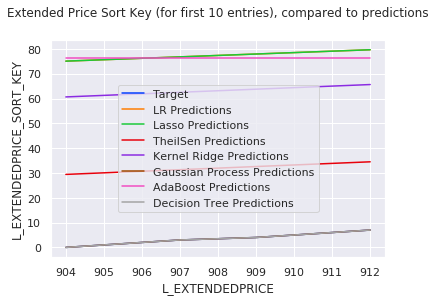

In [0]:
#TODO: Change to show 1000 values. If needed, also add the SVR predictions.

X_plot=df['L_EXTENDEDPRICE']
x_axis= X_plot[:10]
sns.set_palette("bright")
g= sns.lineplot(x=x_axis, y=Y_subset[:10], label="Target")
g= sns.lineplot(ax=g, x=x_axis, y=lr_predict[:10], label="LR Predictions")
g= sns.lineplot(ax=g, x=x_axis, y=lasso_predict[:10], label="Lasso Predictions")
g= sns.lineplot(ax=g, x=x_axis, y=ts_predict[:10], label="TheilSen Predictions")
g= sns.lineplot(ax=g, x=x_axis, y=kr_predict[:10], label="Kernel Ridge Predictions")
g= sns.lineplot(ax=g, x=x_axis, y=gpr_predict[:10], label="Gaussian Process Predictions")
g= sns.lineplot(ax=g, x=x_axis, y=ab_predict[:10], label="AdaBoost Predictions")
g= sns.lineplot(ax=g, x=x_axis, y=dt_predict[:10], label="Decision Tree Predictions")

g.set_title("Extended Price Sort Key (for first 10 entries), compared to predictions", y=1.08)
plt.show()

We see non-linear models perform well, but there is an overhead in their memory footprint. Let's evaluate that. To estimate the memory usage we serialize the models, using the pickle library. 

Optionally, add to this plot (and send) the SVR model's footprint.

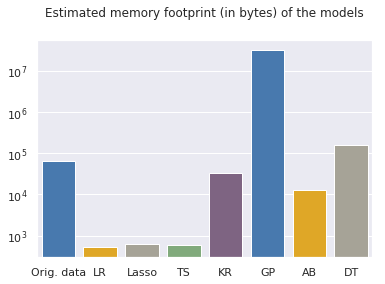

In [0]:
#TODO: If possible, add the SVR model.

import pickle
labels_regressors=["LR", "Lasso", "TS", "KR", "GP", "AB", "DT"]
model_names=["Orig. data"]
model_names.extend(labels_regressors)

memory_footprint_of_models= [
    len(pickle.dumps(Y_subset))+len(pickle.dumps(X_subset)),
    len(pickle.dumps(lr)), 
    len(pickle.dumps(lasso)), 
    len(pickle.dumps(ts)), 
    len(pickle.dumps(kr)),
    len(pickle.dumps(gpr)),
    len(pickle.dumps(ab)),
    len(pickle.dumps(dt))]

for i in range(0,len(labels_regressors)):
  summary[labels_regressors[i]]["Memory (bytes)"]=memory_footprint_of_models[i+1]
  
g = sns.barplot(x=model_names, 
    y=memory_footprint_of_models,palette=sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green", 
                                  "dusty purple"]))
g.set_yscale('log')
g.set_title("Estimated memory footprint (in bytes) of the models", y=1.08)
plt.show()


The memory footprint plot shows that all linear models are notably smaller in their memory usage, when compared to the original data. Models from KR onwards are closer to (or larger) than the size of the original data.

**Bonus:** An open question all the time, when testing a model, is: What is the impact of hyper-parameters? Or stated differently, how can we be sure that we picked the best model configuration?

In the following code snippet is an example of how, in practice, grid search is done, to find the best set of hyper-parameters for a given model.

Please note that the scores will not match those of the algorithm in the previous sections, since the grid search evaluates on splits of test-train. 

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

#Since this throws some warnings, let's not consider them...
import warnings
warnings.filterwarnings("ignore")

parameters = {'kernel':('linear', 'rbf', 'poly'), 'alpha':[0.1, 1.0]}#Other parameters could be included
base_model = KernelRidge()
grid = GridSearchCV(base_model, parameters, cv=2, scoring=make_scorer(mean_absolute_error, greater_is_better=False))
grid.fit(X_subset_scaled, Y_subset)

print("Best parameter set found:")
print(grid.best_params_)

print("Grid scores found:")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
  print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))



Best parameter set found:
{'alpha': 0.1, 'kernel': 'poly'}
Grid scores found:
-620.799 (+/-15.021) for {'alpha': 0.1, 'kernel': 'linear'}
-159.897 (+/-119.187) for {'alpha': 0.1, 'kernel': 'rbf'}
-111.027 (+/-94.427) for {'alpha': 0.1, 'kernel': 'poly'}
-620.674 (+/-14.569) for {'alpha': 1.0, 'kernel': 'linear'}
-447.819 (+/-42.091) for {'alpha': 1.0, 'kernel': 'rbf'}
-248.612 (+/-28.949) for {'alpha': 1.0, 'kernel': 'poly'}


Next, we'll start with a neural network model, which forms a good trade-off between memory footprint and the behavior in the regression task.

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

print("Done importing some necessary dependencies.")

Using TensorFlow backend.


Done importing some necessary dependencies.


In [0]:
#We attempt first a naive implementation that considers all of the data

def NN_regressor():
  model= Sequential()
  model.add(Dense(128,input_dim=1, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dense(1,input_dim=128, kernel_initializer='normal', activation='linear'))
  model.compile(loss='mean_absolute_error', optimizer='adam')
  return model

naive_model = NN_regressor()
naive_model.fit(x=X, y=Y, epochs=10,steps_per_epoch=20,verbose=1)

print("Done with fitting a naive model")


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
20/20 [==============================] - 2s 96ms/step - loss: 16568.0383
Epoch 2/10
20/20 [==============================] - 2s 91ms/step - loss: 12257.4170
Epoch 3/10
20/20 [==============================] - 2s 90ms/step - loss: 5986.6099
Epoch 4/10
20/20 [==============================] - 2s 89ms/step - loss: 1191.9803
Epoch 5/10
20/20 [==============================] - 2s 88ms/step - loss: 897.2357
Epoch 6/10
20/20 [==============================] - 2s 90ms/step - loss: 804.5000
Epoch 7/10
20/20 [==============================] - 2s 91ms/step - loss: 798.7788
Epoch 8/10
20/20 [==============================] - 2s 91ms/step - loss: 798.5313
Epoch 9/10
20/20 [==============================] - 2s 88ms/step - loss: 798.5087
Epoch 10/10
20/20 [==============================] - 2s 87ms/step - loss: 798.5054
Done with fitting a naive model


Training such models over the whole dataset will require some effort. Given the size of datasets, it would be easier to break the learning of the model into a hierarchical solution: At the top a multi-class classifier, deciding which model from underneath would answer to the query. At the bottom, a series of regressors learning on a given subset of data.

This smart idea was suggested by Kraska et al., calling such ensemble a Recursive Index Model. ![alt text](https://adriancolyer.files.wordpress.com/2018/01/learned-index-fig-3.jpeg?w=520)

In the next task, let's build and train one such model consisting of one parent, and 4 regressor nodes as children. 

To this end we need to start by creating a mapping between the L_EXTENDEDPRICE and 4 class
labels corresponding to the children nodes.

Here we will assign labels 0,1,2,3 by breaking the data points based on the quantiles.
To learn about the parameters and configurations available for building networks with Keras, check their documentation: [Keras](https://keras.io/).


In [0]:
price_quantiles=[
    np.quantile(df['L_EXTENDEDPRICE'], .25),
    np.quantile(df['L_EXTENDEDPRICE'], .50),
    np.quantile(df['L_EXTENDEDPRICE'], .75)]

df['classifier_labels']=[0 if x<=price_quantiles[0] 
                      else 
                             1 if x<=price_quantiles[1]
                      else
                             2 if x<=price_quantiles[2]
                      else
                             3 for x in df['L_EXTENDEDPRICE']]

print("Done, with assigning labels to items based on quantiles.")


Done, with assigning labels to items based on quantiles.


In [0]:
from sklearn.utils import shuffle
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical

df = shuffle(df) 

#Some house keeping, encoding the labels
encoder = preprocessing.LabelEncoder()
encoder.fit(df['classifier_labels'])
encoded_Y = encoder.transform(df['classifier_labels'])
# We convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(encoded_Y)

print("Done with some prep to train the recursive model index parent model (the classifier).")

Done with some prep to train the recursive model index parent model (the classifier).


In [0]:
#Here we define and train a multi-class classifier mapping to 4 classes
def NN_classifier():
  model= Sequential()
  model.add(Dense(12,input_dim=1, kernel_initializer='uniform', activation='relu'))
  model.add(Dense(8,input_dim=12, kernel_initializer='uniform', activation='relu'))
  model.add(Dense(output_dim=4,input_dim=8, kernel_initializer='uniform', activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
  return model

#In the following we train a model that should have a classification accuracy higher than 90%
parent_model = NN_classifier()
parent_model.fit(x=df['L_EXTENDEDPRICE'], y=dummy_y, epochs=15,verbose=1)

print("Done with fitting the parent model.")

Epoch 1/15
60175/60175 [==============================] - 2s 37us/step - loss: 1.0365 - acc: 0.5058
Epoch 2/15
60175/60175 [==============================] - 2s 33us/step - loss: 0.6935 - acc: 0.8165
Epoch 3/15
60175/60175 [==============================] - 2s 32us/step - loss: 0.5011 - acc: 0.9075
Epoch 4/15
60175/60175 [==============================] - 2s 33us/step - loss: 0.3849 - acc: 0.9419
Epoch 5/15
60175/60175 [==============================] - 2s 32us/step - loss: 0.2876 - acc: 0.9491
Epoch 6/15
60175/60175 [==============================] - 2s 33us/step - loss: 0.2210 - acc: 0.9591
Epoch 7/15
60175/60175 [==============================] - 2s 32us/step - loss: 0.1825 - acc: 0.9583
Epoch 8/15
60175/60175 [==============================] - 2s 33us/step - loss: 0.1605 - acc: 0.9569
Epoch 9/15
60175/60175 [==============================] - 2s 33us/step - loss: 0.1436 - acc: 0.9606
Epoch 10/15
60175/60175 [==============================] - 2s 33us/step - loss: 0.1302 - acc: 0.9629

Now we have built a classifier. It is time to evaluate it.

In [0]:
#Here we load a model that corresponds to a pre-trained classifier (just to make sure we have a very accurate model for the next steps).

from keras.models import load_model
from urllib.request import urlopen
remote_model_data = urlopen('https://github.com/gabrielcc2/atdbSS2019/raw/master/models/parent_model.h5').read()
f = open('parent_model.h5', 'wb')
f.write(remote_model_data)
parent_model = load_model('parent_model.h5')

print("Done with loading a pre-trained parent model")


Done with loading a pre-trained parent model


In [0]:
#Let's check the accuracy of the model we just loaded (this might take some time)
from sklearn.metrics import accuracy_score

parent_model_preds=[np.argmax(parent_model.predict([x], batch_size=1)) for x in df['L_EXTENDEDPRICE']] #Here the predictions are the positions that ranked higher from the one hot encoding.

print("Accuracy score for pre-trained classifier: "+str(accuracy_score(df['classifier_labels'], parent_model_preds)))

#Now we replace the original labels with those given by the predictor.


Accuracy score for pre-trained classifier: 0.9986206896551724


After building and evaluating the parent model (i.e., the classifier), we can train the leaf nodes.

In [0]:
#We will use the predictions of the parent model to distribute the data to child nodes when training.

df['new_classifier_labels']=parent_model_preds

# The following line could work for checking that all items in X_subset are for the first regressor
#print([np.argmax(parent_model.predict([x], batch_size=1)) for x in X_subset])

print("We stored the predictions of the parent model, to use them as our new labels.")

We stored the predictions of the parent model, to use them as our new labels.


In [0]:
models=[]
print("We created an empty models array, to store the leaf nodes from the recursive model index.")

We created an empty models array, to store the leaf nodes from the recursive model index.


In [0]:
#Now we are going to train the four child regressor models
#This will take some time. You could try changing the number of epochs, to train less.

def NN_regressor():
  model= Sequential()
  model.add(Dense(32,input_dim=1, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(32,input_dim=32, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(128,input_dim=32, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(1,input_dim=128, kernel_initializer='he_uniform', activation='relu'))
  model.compile(loss='mean_squared_error', optimizer='adamax', metrics=['mae'])
  return model

for item in range(0,4):
  if (len(models)==item):
    models.append(NN_regressor())
  else:
    models[item]=NN_regressor()
  df_subset=df[df['new_classifier_labels']==item]
  models[item].fit(x=df_subset['L_EXTENDEDPRICE_SCALED'], y=df_subset['L_EXTENDEDPRICE_SORT_KEY'], epochs=20, verbose=1)
  models[item].save("reg_model_"+str(item)+".h5")
  
print("Great! We created and trained our 4 regressors.")



Epoch 1/20
15030/15030 [==============================] - 1s 57us/step - loss: 17669883.9859 - mean_absolute_error: 3492.5132
Epoch 2/20
15030/15030 [==============================] - 1s 35us/step - loss: 10146529.2752 - mean_absolute_error: 2745.3092
Epoch 3/20
15030/15030 [==============================] - 1s 34us/step - loss: 9736832.5424 - mean_absolute_error: 2690.4224
Epoch 4/20
15030/15030 [==============================] - 1s 35us/step - loss: 9331259.5560 - mean_absolute_error: 2635.7865
Epoch 5/20
15030/15030 [==============================] - 1s 35us/step - loss: 8961560.9320 - mean_absolute_error: 2583.9585
Epoch 6/20
15030/15030 [==============================] - 1s 35us/step - loss: 8459561.7183 - mean_absolute_error: 2511.4204
Epoch 7/20
15030/15030 [==============================] - 1s 35us/step - loss: 7787110.2480 - mean_absolute_error: 2410.1636
Epoch 8/20
15030/15030 [==============================] - 1s 35us/step - loss: 6782491.7329 - mean_absolute_error: 2249.762

That was quite a good job! Now we have one recursive model index.

Please note that the architectures of the parent and leave nodes are not guaranteed to be the best possible ones given our data and the learning task; however they are sufficient to have an end-to-end index.

For those interested in automating network search, here are some references of ongoing projects: [AutoKeras](https://github.com/keras-team/autokeras), [Neural Architecture Search with Reinforcement Learning](https://ai.google/research/pubs/pub45826) and [NAS Bench](https://github.com/google-research/nasbench).

Let's consider next the overall mean absolute error, and the maximum error of our RMI model. To this end, in the next code box, we'll load some pre-trained models for the regressors. You can alternatively skip to the following code box and test your local models.

In [0]:
models=[]
for item in range(0,4):
  remote_model_data = urlopen('https://github.com/gabrielcc2/atdbSS2019/raw/master/models/'+"reg_model_"+str(item)+".h5").read()
  f = open("reg_model_"+str(item)+".h5", 'wb')
  f.write(remote_model_data)
  models.append(load_model("reg_model_"+str(item)+".h5"))
  print("Fetched model #"+str(item))
print("Done fetching remote pre-trained models")

Fetch model #0
Fetch model #1
Fetch model #2
Fetch model #3
Done fetching remote pre-trained models


This might take some time to run.

In [0]:
def max_absolute_error(y, y_pred):
    return np.max(np.abs(y - y_pred))

mean_absolute_errors=[]
max_absolute_errors=[]
max_error=0
for item in range(0,4):
  df_subset=df[df['new_classifier_labels']==item]
  x_=df_subset['L_EXTENDEDPRICE_SCALED']
  y_=df_subset['L_EXTENDEDPRICE_SORT_KEY']
  preds=[models[item].predict([x], batch_size=1)[0] for x in x_]
  mean_absolute_errors.append(mean_absolute_error(y_, preds))
  preds=np.array(preds)
  preds=preds.reshape(np.shape(preds)[0])
  error= max_absolute_error(y_, preds)
  max_absolute_errors.append(error)
  if error>max_error:
    max_error=error

print("(Drumrolls please...)")
print("****Results for the Recursive Model Index (on the complete data)****")
print("Mean absolute error per model: ")
print(mean_absolute_errors)
print("Mean absolute error: "+str(np.mean(mean_absolute_errors)))
print("Max absolute error per model: ")
print(max_absolute_errors)
print("Max error: "+str(max_error))

(Drumrolls please...)
****Results for the Recursive Model Index (on the complete data)****
Mean absolute error per model: 
[13.83043885716421, 8.029194516493748, 6.442378805957186, 11.7813375175035]
Mean absolute error: 10.02083742427966
Max absolute error per model: 
[67.30945, 26.09375, 31.330078, 41.216797]
Max error: 67.30945


Mean absolute error for RMI: 20.960401087760925
Max error for RMI: 67.30945


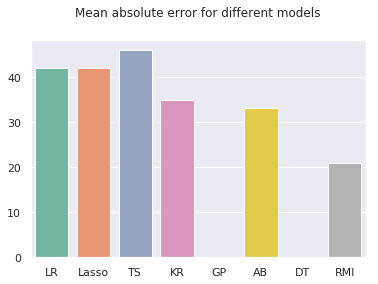

In [0]:
#Here we calculate the errors on X_subset, such that we can compare it with the regressors we trained at the start
max_error=0
preds=[models[0].predict([x], batch_size=1)[0] for x in X_subset_scaled]
rmi_mae = mean_absolute_error(Y_subset, preds)
for i in range(0,len(Y_subset)):
  if Y_subset.iloc[i]>preds[i]:
    error= Y_subset.iloc[i]-preds[i]
  else:
    error= preds[i]-Y_subset.iloc[i]
  if error>max_error:
    max_error=error[0]

summary["RMI"]=dict()
summary["RMI"]["Mean Absolute Error"]=rmi_mae
summary["RMI"]["Max Absolute Error"]=max_error

print("Mean absolute error for RMI: "+str(rmi_mae))
print("Max error for RMI: "+str(max_error))


sns.set_palette("Set2")
names=list(summary.keys())
g = sns.barplot(x=names, y=[summary[key]["Mean Absolute Error"] for key in names])
g.set_title("Mean absolute error for different models", y=1.08)
plt.show()



RMI should not be doing that bad in this subset.

Pack the previous plot and the following plot, these are your **submission items #4 and #5**. With this you conclude the assignment, but you are welcome to check the extra task, to learn more.

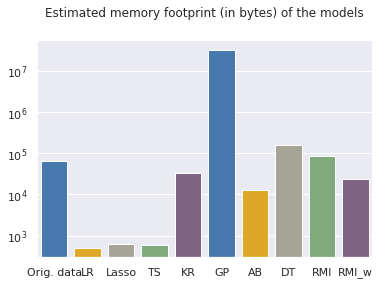

In [0]:

model_names=["Orig. data", "LR", "Lasso", "TS", "KR", "GP", "AB", "DT"]
memory_footprint_of_models= [
    len(pickle.dumps(Y_subset))+len(pickle.dumps(X_subset)),
    len(pickle.dumps(lr)), 
    len(pickle.dumps(lasso)), 
    len(pickle.dumps(ts)), 
    len(pickle.dumps(kr)),
    len(pickle.dumps(gpr)),
    len(pickle.dumps(ab)),
    len(pickle.dumps(dt))]

model_names.append("RMI")
memory_footprint_of_models.append(len(pickle.dumps(models[0]))+len(pickle.dumps(parent_model)))

model_names.append("RMI_w")
memory_footprint_of_models.append(len(pickle.dumps(models[0].get_weights()))+len(pickle.dumps(parent_model.get_weights())))
summary["RMI"]["Memory (bytes)"]=len(pickle.dumps(models[0].get_weights()))+len(pickle.dumps(parent_model.get_weights()))

g = sns.barplot(x=model_names, 
    y=memory_footprint_of_models,palette=sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green", 
                                  "dusty purple"]))
g.set_yscale('log')
g.set_title("Estimated memory footprint (in bytes) of the models", y=1.08)
plt.show()

As a result, we see that the recursive model index we built, using neural networks represents a good solution for having a low mean absolute error, low maximum absolute error, and a limited memory footprint, when compared to other models. 

In our implementation, depending on our choice of neural architecture, it might be that Decision Trees seem to be better solutions in the trade-off between memory efficiency and mean average error.

Smaller network structures could also be employed, reducing the footprint of the RMIs. This approach is also comparatively promising when considering only the weights that need to be kept (as RMI_w in the plot).

**This section concludes the programming assignment. **

In an extra section you can (optionally) evaluate the structure that we built, considering how it performs in the search task.

In [0]:
"""To wrap things up, let's make a summary, to get a better sense of the trade-offs.
"""
print(pd.DataFrame.from_dict(summary).transpose())

             MAE       MaxAE  Memory (bytes)
LR     41.996683   99.814321           515.0
Lasso  41.996747   99.814597           628.0
TS     45.955019  136.747279           579.0
KR     34.915409   90.630653         32421.0
GP      0.000002    0.001386      32051794.0
AB     33.066905   77.248201         12960.0
DT      0.000000    0.000000        153451.0
RMI    20.960401   67.309448         23329.0


# Takeaways

Kudos! You made it to the end of this programming assignment :)

For students of the "Advanced Topics in Databases" course, please pack in a zip file **submission items #1-#5**, and send them to: campero@ovgu.de. This constitutes your submission, to be evaluated. The deadline is 30.06.19, 11:59 pm CET. Please add some feedback to the submission email, answering at least to the following questions: 
1.   On a scale from 1-5 (great to terrible), did you find this assignment to be relevant in developing skills useful for your professional path? 
2.  How would you rate the difficulty of the assignment, on a 1-5 scale (from very easy to very difficult)?
3. What suggestions for improvement would you like us to consider?

By the end of this assignment you should:

1. Understand some of the key ideas for using *learned models* to solve everyday computing tasks: the role of the cummulative distribution function and how recursive model indexes can be built.
2.  Be more familiarized with colab, pandas, seaborn, sklearn and keras, as a set of tools for building models and data exploration.
3. Be encouraged to think on machine learning models with a practical perspective, considering their memory footprint and details that affect their execution time.

![](https://drive.google.com/uc?export=view&id=1AjWDi6cnpxY21WExPRa7ltXmzts7RvHs)

If you successfully completed this task, you found it to be enjoyable & would like to collaborate in researching applications of AI techniques in data management, please contact: campero@ovgu.de.

If you would like to know more about the challenges for building automatically this kind of index structures, in a real-world scenario, and managing ML models in production, here is a good reference on the monitoring and testing tasks that are required: Breck, Eric, Shanqing Cai, Eric Nielsen, Michael Salib, and D. Sculley. "The ml test score: A rubric for ml production readiness and technical debt reduction." In 2017 IEEE International Conference on Big Data (Big Data), pp. 1123-1132. IEEE, 2017.
Further work advancing learned index structures should be ultimately visible [here](https://scholar.google.de/scholar?cites=15186041802906124026&as_sdt=2005&sciodt=0,5&hl=en). Of special note we would like to highlight some interesting recent work: Ding, Jialin, Umar Farooq Minhas, Hantian Zhang, Yinan Li, Chi Wang, Badrish Chandramouli, Johannes Gehrke, Donald Kossmann, and David Lomet. "ALEX: An Updatable Adaptive Learned Index." arXiv preprint arXiv:1905.08898 (2019).

# Extra part (Optional): Efficient Inference

(Estimated time: 40 minutes)

To be added, stay tuned.